<h1 align="center" style=font-size:50px>Bank Customer Churn Prediction</h1>
<h3 align="center" style=font-size:30px>Modelagem</h3>
<h6 align="center" style=font-size:20px>Nessa etapa, vai ser desenvolvido um modelo de machine learning usando a regressão logística para prever se um cliente do banco vai dar churn ou não.</h6>

In [208]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score,confusion_matrix, roc_curve,roc_auc_score,precision_recall_curve,precision_score,recall_score,auc,f1_score
from sklearn.feature_selection import f_classif,SelectPercentile
from sklearn.preprocessing import OneHotEncoder, TargetEncoder,MinMaxScaler,MaxAbsScaler,PolynomialFeatures,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif,SelectPercentile

In [209]:
# carregando o data set
df = pd.read_csv('../data/Churn_Modelling.csv')

In [210]:
# Separando as features e a response variable
X = df.drop(['RowNumber', 'CustomerId','Surname','Exited'],axis=1)
y = df['Exited']

In [211]:
# Separando em treino e teste
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=24)

In [212]:
# Fazendo o pre-processamento
categorical_features = ['Geography','Gender']
numerical_features = X.drop(categorical_features,axis=1).columns

numerical_features_transform = StandardScaler()
categorical_features_transform = Pipeline(steps=[('targetencoder',TargetEncoder()),
                                                ('scaler',StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num',numerical_features_transform,numerical_features),
                                               ('cat',categorical_features_transform,categorical_features)])

model_lr = LogisticRegression(penalty='l1',solver='liblinear')

lr = Pipeline(steps=[('preprocessor',preprocessor),
                     ('feature_sel',SelectPercentile(f_classif,percentile=50)),
                     ('model',model_lr)])

In [213]:
# criando uma cross-validation para escolher o melhor hipermarâmetro C
def cross_validation_search_C(model: Pipeline, X_train: pd.DataFrame, y_train: pd.DataFrame, n_folds: int, C_vals):
    n_folds = n_folds
    stratified_kfolds = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=0)
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[] for _ in range(len(C_vals))]

    for c_val_counter in range(len(C_vals)):
        
        model.set_params(model__C = C_vals[c_val_counter])
        fold_counter = 0
        for train_index, test_index in stratified_kfolds.split(X_train, y_train):

            X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
            y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]

            model.fit(X_cv_train, y_cv_train)
            
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])

            #Get the test ROC AUC
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            
            #Test ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            
            fold_counter += 1

        
            
        print(f'Done with C = {model.get_params()['model__C']}')

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [214]:
# número de kfolds
n_folds=5
# lista contendo os valores para C
C_vals_expoents = np.linspace(3,-3,13)
C_vals = 10.0**C_vals_expoents
#cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_validation_search_C(lr, X_train, y_train, n_folds, C_vals)


In [215]:
#def cross(model: Pipeline, X_train: pd.DataFrame, y_train: pd.DataFrame, n_folds: int, C_vals):
    

In [216]:
""" # Plotando a média do score da cross validation de todos os folder
fig = go.Figure()
colors = ['#7ABA78','#0A6847','#C3FF93','#F6E9B2','#F3CA52']

fig.add_trace(go.Scatter(x=C_vals_expoents,y=np.mean(cv_train_roc_auc,axis=0),mode='lines+markers',
                             name=f'Averaging training score',marker_color='#7ABA78'))
fig.add_trace(go.Scatter(x=C_vals_expoents,y=np.mean(cv_test_roc_auc,axis=0),mode='lines+markers',
                             marker_symbol='x',name=f'Averaging test score',marker_color='#0A6847'))

fig.update_layout(title='<b>Média do score da cross validation de todos os folder</b>',template='simple_white',font_family='RockWell')
fig.update_yaxes(title = dict(text='Roc AUC'),linecolor='silver')
fig.update_xaxes(title = r'$log_{10}(C)$',linecolor='silver')
fig.show('png',scale=2,width=500) """

" # Plotando a média do score da cross validation de todos os folder\nfig = go.Figure()\ncolors = ['#7ABA78','#0A6847','#C3FF93','#F6E9B2','#F3CA52']\n\nfig.add_trace(go.Scatter(x=C_vals_expoents,y=np.mean(cv_train_roc_auc,axis=0),mode='lines+markers',\n                             name=f'Averaging training score',marker_color='#7ABA78'))\nfig.add_trace(go.Scatter(x=C_vals_expoents,y=np.mean(cv_test_roc_auc,axis=0),mode='lines+markers',\n                             marker_symbol='x',name=f'Averaging test score',marker_color='#0A6847'))\n\nfig.update_layout(title='<b>Média do score da cross validation de todos os folder</b>',template='simple_white',font_family='RockWell')\nfig.update_yaxes(title = dict(text='Roc AUC'),linecolor='silver')\nfig.update_xaxes(title = r'$log_{10}(C)$',linecolor='silver')\nfig.show('png',scale=2,width=500) "

Observando o gráfico acima, vemos que o o melhor número para C foi $10^{1}$

In [217]:
"""  # plotando a roc curve para cada fold com C = 10^{1}
best_C_value_index = C_vals_expoents==-2.5
best_C_value_index = np.nonzero(best_C_value_index.astype(int))
best_C_value_index
fig2 = go.Figure()
colors = ['#7ABA78','#0A6847','#C3FF93','#F6E9B2','#F3CA52']
for this_fold in range(0,n_folds):
    fpr = cv_test_roc[best_C_value_index[0][0]][this_fold][0]
    tpr = cv_test_roc[best_C_value_index[0][0]][this_fold][1]
    fig2.add_trace(go.Scatter(x=fpr,y=tpr,mode='lines',name=f'Fold {this_fold+1}',marker_color=colors[this_fold]))
fig2.update_layout(title='<b>Roc Curve para cada fold com C = 10^{1.5}',template='simple_white',font_family='RockWell')
fig2.update_yaxes(title = dict(text='TPR'),linecolor='silver')
fig2.update_xaxes(title = dict(text='FPR'),linecolor='silver')
fig2.show('png',scale=2,width=500) """

"  # plotando a roc curve para cada fold com C = 10^{1}\nbest_C_value_index = C_vals_expoents==-2.5\nbest_C_value_index = np.nonzero(best_C_value_index.astype(int))\nbest_C_value_index\nfig2 = go.Figure()\ncolors = ['#7ABA78','#0A6847','#C3FF93','#F6E9B2','#F3CA52']\nfor this_fold in range(0,n_folds):\n    fpr = cv_test_roc[best_C_value_index[0][0]][this_fold][0]\n    tpr = cv_test_roc[best_C_value_index[0][0]][this_fold][1]\n    fig2.add_trace(go.Scatter(x=fpr,y=tpr,mode='lines',name=f'Fold {this_fold+1}',marker_color=colors[this_fold]))\nfig2.update_layout(title='<b>Roc Curve para cada fold com C = 10^{1.5}',template='simple_white',font_family='RockWell')\nfig2.update_yaxes(title = dict(text='TPR'),linecolor='silver')\nfig2.update_xaxes(title = dict(text='FPR'),linecolor='silver')\nfig2.show('png',scale=2,width=500) "

In [218]:
# função para avaliar o modelo
def avalaibe_lr(lr: LogisticRegression,X_train: pd.DataFrame,X_test: pd.DataFrame,y_train: pd.Series, y_test: pd.Series,best_value_C: float) -> pd.DataFrame:
    lr.C = best_value_C
    lr.fit(X_train,y_train)
    
    y_pred = lr.predict(X_test)
    
    y_pred_proba = lr.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test,y_pred)
    
    recall = recall_score(y_test,y_pred)
    
    roc_auc = roc_auc_score(y_test,y_pred_proba[:,1])
    
    precision = precision_score(y_test,y_pred,zero_division=1)

    f1_sr = f1_score(y_test,y_pred)
    df_metrics = pd.DataFrame(data=[[accuracy,recall,roc_auc,precision,f1_sr]],columns=['Accuracy','Recall','ROC AUC','Precision','F1 Score'])
    return df_metrics




In [219]:
best_value_C = 10**(-2)
df_metrics = avalaibe_lr(lr, X_train,X_test,y_train, y_test,best_value_C)
df_metrics

,Accuracy,Recall,ROC AUC,Precision,F1 Score
0,0.8125,0.200969,0.774574,0.648438,0.306839


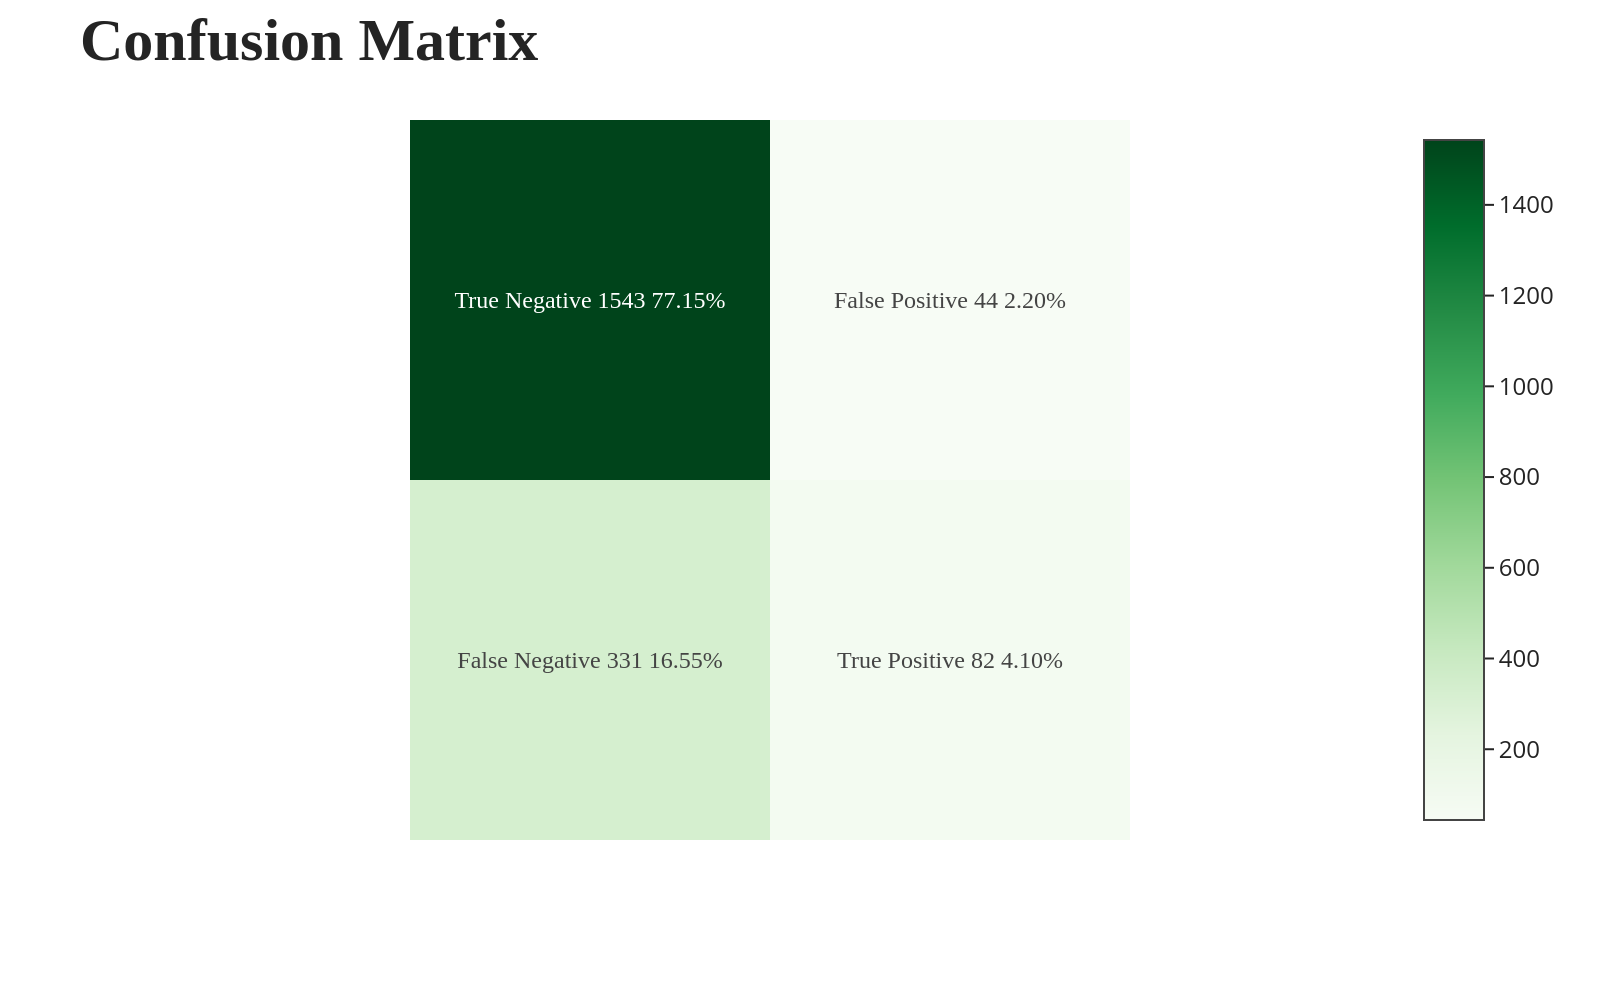

In [220]:
# função que plota  matriz de confusão
def plot_cunfusion_matrix(lr: LogisticRegression,X_train: pd.DataFrame,X_test: pd.DataFrame,y_train: pd.Series,y_test: pd.Series) -> None:

    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    names = ['True Negative','False Positive','False Negative','True Positive']
    counts = [num for num in cm.flatten()]
    percents = [f'{num:.2%}' for num in cm.flatten()/np.sum(cm)]
    labels = [f'{value_1}\n{value_2}\n{value_3}' for value_1,value_2,value_3 in zip(names,counts,percents)]
    labels = np.asarray(labels).reshape(2,2)
    fig = px.imshow(cm,x=['0','1'],y=['0','1'],color_continuous_scale='greens')
    fig.update_traces(text=labels,texttemplate='%{text}',textfont = dict(size=12,family='Rockwell'))
    fig.update_layout(title = dict(text='<b>Confusion Matrix</b>',font_family='RockWell',font_size=30),width=500,template='simple_white')
    fig.update_yaxes(showline=False,showticklabels=False,ticks='')
    fig.update_xaxes(showline=False,showticklabels=False,ticks='')
    fig.show('png',scale=2,width=800)

plot_cunfusion_matrix(lr,X_train,X_test,y_train,y_test)